In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
import numpy as np
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram as plt_hist
from scipy.optimize import minimize
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import ParameterVector
from matplotlib import pyplot as plt

In [20]:
t = ParameterVector('t', length = 9)
num_qubits = 5
ansatz = RealAmplitudes(num_qubits, reps=1)
#theta_list = [1,2,3,4,5,6]
#ansatz.assign_parameters(theta_list, inplace = True)


qbit = QuantumRegister(num_qubits)
cbit = ClassicalRegister(num_qubits)



zz_qc = QuantumCircuit(qbit, cbit)
zz_qc.append(ansatz, [i for i in range(num_qubits)])
zz_qc.measure(qbit[:], cbit[:])


print(ansatz)

     ┌──────────┐                              ┌──────────┐                 »
q_0: ┤ Ry(θ[0]) ├──■────■─────────■─────────■──┤ Ry(θ[5]) ├─────────────────»
     ├──────────┤┌─┴─┐  │         │         │  └──────────┘     ┌──────────┐»
q_1: ┤ Ry(θ[1]) ├┤ X ├──┼────■────┼────■────┼────────────────■──┤ Ry(θ[6]) ├»
     ├──────────┤└───┘┌─┴─┐┌─┴─┐  │    │    │                │  └──────────┘»
q_2: ┤ Ry(θ[2]) ├─────┤ X ├┤ X ├──┼────┼────┼───────■────────┼───────■──────»
     ├──────────┤     └───┘└───┘┌─┴─┐┌─┴─┐  │     ┌─┴─┐      │       │      »
q_3: ┤ Ry(θ[3]) ├───────────────┤ X ├┤ X ├──┼─────┤ X ├──────┼───────┼──────»
     ├──────────┤               └───┘└───┘┌─┴─┐   └───┘    ┌─┴─┐   ┌─┴─┐    »
q_4: ┤ Ry(θ[4]) ├─────────────────────────┤ X ├────────────┤ X ├───┤ X ├────»
     └──────────┘                         └───┘            └───┘   └───┘    »
«                             
«q_0: ────────────────────────
«                             
«q_1: ────────────────────────
«     ┌──────────┐

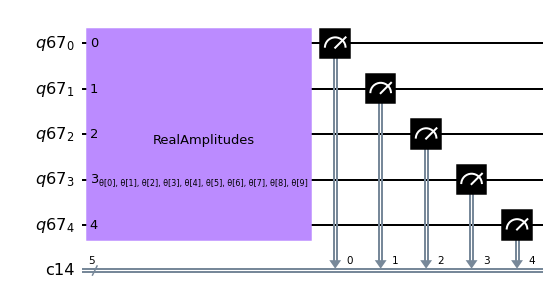

In [25]:
zz_qc.draw('mpl')

In [5]:
def x_measurecir_realamp(theta_list, num_qubits):
    qbits = QuantumRegister(num_qubits)
    cbits = ClassicalRegister(num_qubits)
    
    ansatz = RealAmplitudes(num_qubits, reps = 1)
    ansatz.assign_parameters(theta_list, inplace = True)
    x_qc = QuantumCircuit(qbits, cbits)
    
    x_qc.append(ansatz, [i for i in range(num_qubits)])
    x_qc.h(qbits[:])
    x_qc.measure(qbits[:], cbits[:])
    
    return x_qc

def zz_measurecir_realamp(theta_list, num_qubits):
    qbits = QuantumRegister(num_qubits)
    cbits = ClassicalRegister(num_qubits)
    
    ansatz = RealAmplitudes(num_qubits, reps = 1)
    ansatz.assign_parameters(theta_list, inplace = True)
    zz_qc = QuantumCircuit(qbits, cbits)
    
    zz_qc.append(ansatz, [i for i in range(num_qubits)])
    zz_qc.measure(qbits[:], cbits[:])
    
    return zz_qc

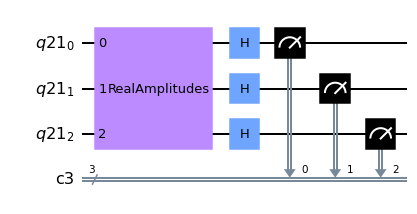

In [8]:
x_measurecir_realamp([1,2,3,4,5,6], 3).draw('mpl')

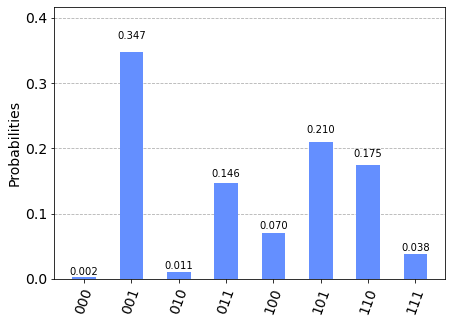

In [7]:
numshots = 10000
backend = Aer.get_backend('qasm_simulator')

qc = x_measurecir_realamp([1,2,3,4,5,6], 3)
qc_transpiled = transpile(qc, backend)
job = assemble(qc_transpiled, backend = backend, shots = numshots)
results = backend.run(job).result()
counts = results.get_counts()

plt_hist(counts)

In [29]:
def x_measure(num_qubits, h, x_counts):
    x_exp = 0
    for i in range(num_qubits):
        x_exp_i = 0
        for key in x_counts:
        
            if key[i] == '0':
                sign = +1
            else:
                sign = -1
            
            x_exp_i += sign * x_counts[key]/ numshots
            
        x_exp += x_exp_i
    
    return - h * x_exp

def zz_measure(num_qubits, zz_counts): 
    zz_exp = 0
    for i in range(num_qubits):
        zz_exp_i = 0
        if i == num_qubits -1:
            for key in zz_counts:
                if key[0] == key[-1]:
                    sign = +1
                else:
                    sign = -1
                zz_exp_i += sign * (zz_counts[key] / numshots)
            
        else:
            for key in zz_counts:
                if key[i] == key[i+1]:
                    sign = +1
                else:
                    sign = -1
                zz_exp_i += sign * (zz_counts[key] / numshots)
        zz_exp += zz_exp_i
        
    return - zz_exp

def hamiltonian_measure(num_qubits, h, zz_counts, x_counts):
    return zz_measure(num_qubits, zz_counts) + x_measure(num_qubits, h, x_counts)

In [30]:
def objective_function(theta_list, num_qubits, h ):
    
    #get backend
    backend = Aer.get_backend('qasm_simulator')
    numshots = 10000

    #measure term ZZ
    zz_qc = zz_measurecir_realamp(theta_list, num_qubits)
    zz_qc_transpile = transpile(zz_qc, backend = backend)
    zz_job = assemble(zz_qc_transpile, backend = backend, shots = numshots)
    zz_result = backend.run(zz_job).result()
    zz_counts = zz_result.get_counts()
    
    #measure term X
    x_qc = x_measurecir_realamp(theta_list, num_qubits)
    x_qc_transpile = transpile(x_qc, backend = backend)
    x_job = assemble(x_qc_transpile, backend = backend, shots = numshots)
    x_result = backend.run(x_job).result()
    x_counts = x_result.get_counts()
    

    h_exp = hamiltonian_measure(num_qubits, h, zz_counts, x_counts)
    
    return h_exp



In [31]:
%%time
sol1 = minimize(fun = objective_function, args = (3,2) ,x0 = [1,2,3,4,5,6]  ,method = 'COBYLA')

CPU times: user 4.05 s, sys: 104 ms, total: 4.16 s
Wall time: 4.32 s


In [32]:
sol1.fun

-6.2308

In [35]:
%%time
#with open('RealAmplitudes_E_range.txt', 'w') as outfile:
#    
#    for num_qubits in range(1,5,1):
#        E_range = []
#        h_range = np.linspace(0, 2, 20)
#        x0 = [0] * (num_qubits * 2)
#        
#        for h in h_range:
#            sol = minimize(fun = objective_function, args = (num_qubits, h) ,x0 = x0 ,method = 'COBYLA')
#            E_value = sol.fun
#            E_range.append(E_value)
#            x0 = sol.x
#
#        E_range = list(map(lambda x: x/num_qubits, E_range))
#        
#        for i in range(len(E_range)-1):
#            outfile.write('{ground_energy} '.format(ground_energy = E_range[i]))
#        outfile.write('{}\n'.format(E_range[-1]))`

CPU times: user 3min 48s, sys: 3.32 s, total: 3min 51s
Wall time: 3min 55s


In [36]:
def get_E_range(filename, n):
    with open(filename, 'r') as infile:
        for i in range(1, n+1):
            line = infile.readline().split(' ')
    E_range = []
    for element in line:
        E_range.append(complex(element))
        
    return E_range

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


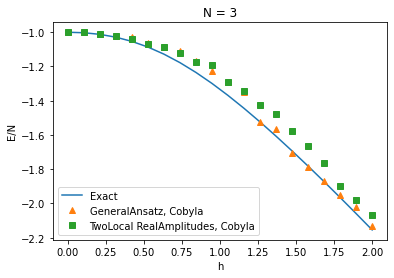

In [51]:
h_range = np.linspace(0,2,20)
num_qubits = 3
Exact_E_range = get_E_range('Exact_E_range.txt', num_qubits)
GeneralAnsatz_E_range = get_E_range('GeneralAnsatz_E_range.txt', num_qubits)
RealAmplitudes_E_range = get_E_range('RealAmplitudes_E_range.txt', num_qubits)

plt.plot(h_range, Exact_E_range, label = 'Exact')
plt.plot(h_range, GeneralAnsatz_E_range, '^', label = 'GeneralAnsatz, Cobyla')
plt.plot(h_range, RealAmplitudes_E_range, 's', label = 'TwoLocal RealAmplitudes, Cobyla')

plt.xlabel('h')
plt.ylabel('E/N')
plt.title('N = {}'.format(num_qubits))
plt.legend()
plt.show()

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


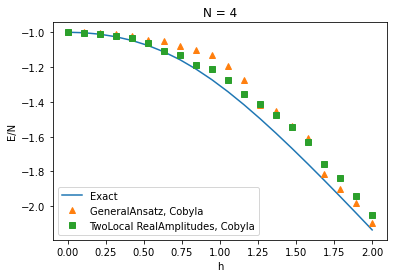

In [52]:
h_range = np.linspace(0,2,20)
num_qubits = 4
Exact_E_range = get_E_range('Exact_E_range.txt', num_qubits)
GeneralAnsatz_E_range = get_E_range('GeneralAnsatz_E_range.txt', num_qubits)
RealAmplitudes_E_range = get_E_range('RealAmplitudes_E_range.txt', num_qubits)

plt.plot(h_range, Exact_E_range, label = 'Exact')
plt.plot(h_range, GeneralAnsatz_E_range, '^', label = 'GeneralAnsatz, Cobyla')
plt.plot(h_range, RealAmplitudes_E_range, 's', label = 'TwoLocal RealAmplitudes, Cobyla')

plt.xlabel('h')
plt.ylabel('E/N')
plt.title('N = {}'.format(num_qubits))
plt.legend()
plt.show()